# Import packages

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

# Exercise 1: Model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation

506


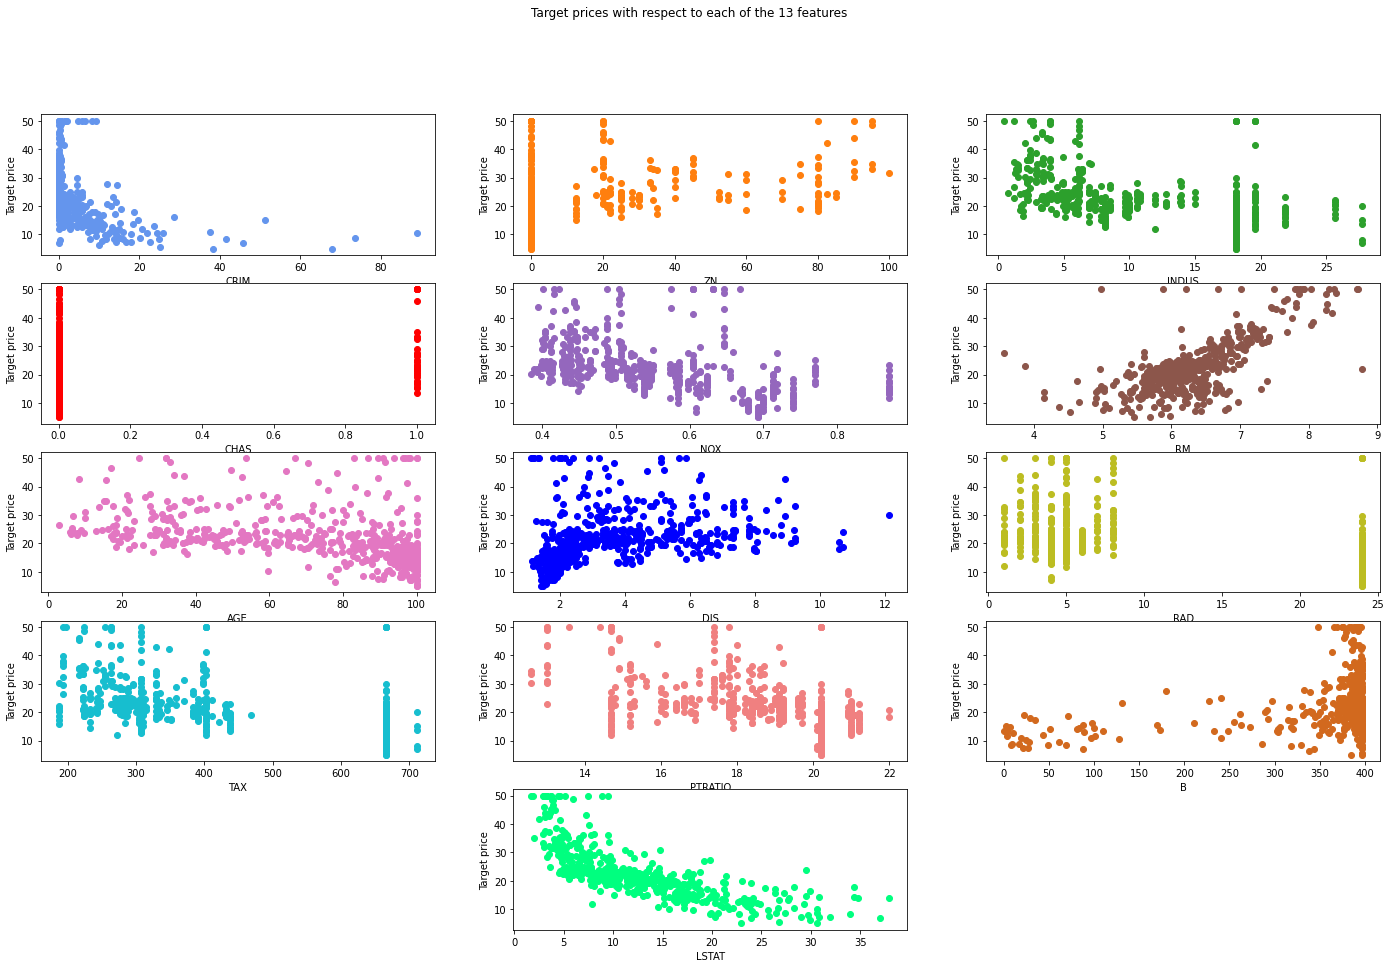

In [8]:
### Load Boston dataset:
boston = load_boston()
X = boston.data
Y = boston.target
print(Y)
# Display scatterplots of target prices with respect to each of the 13 features:
colors = ['cornflowerblue',
          'tab:orange',
          'tab:green',
          'r',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'b',
          'tab:olive',
          'tab:cyan',
          'lightcoral',
          'chocolate',
          'springgreen']
for col in range(X.shape[1]):
    plt.figure(1, figsize=(24, 15))
    if col < X.shape[1] - 1:
        plot_idx = col+1
    else:
        plot_idx = 14
    plt.subplot(5, 3, plot_idx)
    plt.scatter(X[:,col], Y, marker='o', c=colors[col])
    plt.xlabel(boston.feature_names[col])
    plt.ylabel('Target price')
plt.suptitle("Target prices with respect to each of the 13 features")
plt.show()

The target prices appear to be strongly correlated to several continuous features... among them, features 5 ("RM") and 12 ("LSTAT").

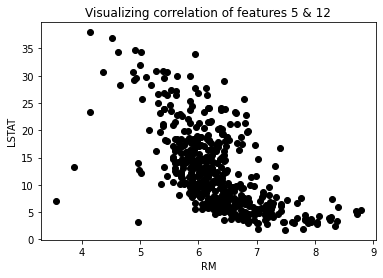

In [5]:
plt.figure(2)
plt.scatter(X[:,5], X[:,12], c='k')
plt.title("Visualizing correlation of features 5 & 12")
plt.xlabel(boston.feature_names[5])
plt.ylabel(boston.feature_names[12])
plt.show()

Features 5 and 12 appear to be visually sufficiently decorrelated. Let us choose these two features as a subset of the full features matrix:

In [ ]:
X = X[:,[5,12]]

In [ ]:
### Select a Ridge model on a list of hyper-parameters instances, via regular validation:
def regular_model_selection(X, Y, hyper_parameters_instances, seed):
    # Extract a test set:
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=seed)
    # Extract a validation set:
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, shuffle=True, random_state=seed)
    # For each hyper-parameter instance, do regular validation:
    val_MSEs = []
    for hyper_parameters_instance in hyper_parameters_instances:
        print("\nNow preprocessing hyper-parameter instance", hyper_parameters_instance)
        val_MSE = assess_Ridge(X_train=X_train, 
                               X_eval=X_val,
                               Y_train=Y_train,
                               Y_eval=Y_val,
                               degree=hyper_parameters_instance["degree"],
                               regularization=hyper_parameters_instance["regularization"])
        print("Validation MSE:", val_MSE)
        val_MSEs.append(val_MSE)
    # The hyper-parameter instance with the smallest validation MSE is our model of choice:
    best_instance_idx = np.argmin(np.array(val_MSEs))
    best_hyper_parameters_instance = hyper_parameters_instances[best_instance_idx]
    print("\n\nBest hyper-parameter instance:", best_hyper_parameters_instance)
    # Train the best model on the whole train set then evaluate it on the test set:
    best_model_test_MSE = assess_Ridge(X_train=X_train_val, 
                                       X_eval=X_test,
                                       Y_train=Y_train_val,
                                       Y_eval=Y_test,
                                       degree=best_hyper_parameters_instance["degree"],
                                       regularization=best_hyper_parameters_instance["regularization"])
    print("Test MSE:", best_model_test_MSE)

### Split+shuffle X and Y into k=num_folds different folds:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

### Select a Ridge model on a list of hyper-parameters instances, via Kfold cross-validation:
def KFold_model_selection(X, Y, hyper_parameters_instances, num_folds, seed):
    # Extract a test set:
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=seed)
    # Extract train and validation folds:
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X_train_val, Y_train_val, num_folds, seed)
    # For each hyper-parameter instance, do KFold cross validation:
    mean_val_MSEs = []
    for hyper_parameters_instance in hyper_parameters_instances:
        print("\nNow preprocessing hyper-parameter instance", hyper_parameters_instance)
        mean_val_MSE = perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, 
                                        degree=hyper_parameters_instance["degree"], 
                                        regularization=hyper_parameters_instance["regularization"])
        print("Mean validation MSE:", mean_val_MSE)
        mean_val_MSEs.append(mean_val_MSE)
    # The hyper-parameter instance with the smallest mean validation MSE is our model of choice:
    best_instance_idx = np.argmin(np.array(mean_val_MSEs))
    best_hyper_parameters_instance = hyper_parameters_instances[best_instance_idx]
    print("\n\nBest hyper-parameter instance:", best_hyper_parameters_instance)
    # Train the best model on the whole train set then evaluate it on the test set:
    best_model_test_MSE = assess_Ridge(X_train=X_train_val, 
                                       X_eval=X_test,
                                       Y_train=Y_train_val,
                                       Y_eval=Y_test,
                                       degree=best_hyper_parameters_instance["degree"],
                                       regularization=best_hyper_parameters_instance["regularization"])
    print("Test MSE:", best_model_test_MSE)
    
### KFold cross-validation of a Ridge model with given hyper-parameters:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, degree, regularization):
    val_fold_MSEs = []
    # For each fold, assess a surrogate model with fixed hyper-parameters:
    cmpt = 0
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        val_fold_MSE = assess_Ridge(X_train=X_train_fold, 
                                    X_eval=X_val_fold,
                                    Y_train=Y_train_fold,
                                    Y_eval=Y_val_fold,
                                    degree=degree,
                                    regularization=regularization)
        cmpt += 1
        print("Surrogate model", str(cmpt) + "/" + str(len(X_val_folds)), "validation MSE:", val_fold_MSE)
        val_fold_MSEs.append(val_fold_MSE)
    # Compute the mean validation MSE between all the folds:
    mean_val_MSE = np.mean(np.array(val_fold_MSEs))
    return mean_val_MSE

### Fit and evaluate a Ridge model with given hyper-parameters:
def assess_Ridge(X_train, X_eval, Y_train, Y_eval, degree, regularization):
    # Build the polynomial features:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_eval_poly = poly_features.fit_transform(X_eval)
    # Fit the polynomial features with a Ridge model:
    model = Ridge(alpha=regularization)
    model.fit(X_train_poly, Y_train)
    # Evaluate the Ridge model on the evaluation set:
    Y_eval_pred = model.predict(X_eval_poly)
    eval_MSE = mean_squared_error(Y_eval, Y_eval_pred)
    return eval_MSE

In [ ]:
# Create the list of hyper-parameters instances:
hyper_parameters_instances = [{"degree": 1, "regularization": 0},
                              {"degree": 2, "regularization": 0},
                              {"degree": 3, "regularization": 0},
                              {"degree": 4, "regularization": 0},
                              {"degree": 1, "regularization": 0.001},
                              {"degree": 2, "regularization": 0.001},
                              {"degree": 3, "regularization": 0.001},
                              {"degree": 4, "regularization": 0.001},
                              {"degree": 1, "regularization": 0.01},
                              {"degree": 2, "regularization": 0.01},
                              {"degree": 3, "regularization": 0.01},
                              {"degree": 4, "regularization": 0.01},
                              {"degree": 1, "regularization": 0.1},
                              {"degree": 2, "regularization": 0.1},
                              {"degree": 3, "regularization": 0.1},
                              {"degree": 4, "regularization": 0.1}]

In [ ]:
### Model selection of a Ridge model on a list of hyper-parameters instances with regular validation:
# Fix random seed for reproducibility:
#seed = 333
# Or not:
seed = None
# Select model with regular validation:
regular_model_selection(X, Y, hyper_parameters_instances, seed=seed)

In [ ]:
### Model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation:
# Fix random seed for reproducibility:
#seed = 333
# Or not:
seed = None
# Select model with KFold cross-validation:
KFold_model_selection(X, Y, hyper_parameters_instances, num_folds=5, seed=seed)

A singular matrix warning indicates that the matrix containing the data has columns that are approximately linearly dependant, thus the matrix becomes close to singular. 

Increasing the regularization hyper-parameter will eventually get rid of this warning. Indeed, recall that the Ridge model solves $\underset{w}{\min} \|y-Xw\|_2^2 + \alpha\|w\|_2^2$ by nullifying the gradient, which yields a unique solution given by $w_{sol} = (X^tX + \alpha I)^{-1} X^ty$. The higher the $\alpha$ in $X^tX + \alpha I$, the more dominant the identity matrix term becomes compared to the potentially singular matrix term $X^tX$. When the identity matrix is dominant enough the matrix $X^tX + \alpha I$ becomes invertible i.e. non-singular. 

Intuitively, the penalization term $\alpha\|w\|_2^2$ forces the model to shrink the minimizer $w_{sol}$ toward $0$ (the bigger $\alpha$ is, the stronger the shrinkage), which lowers the impact from irrelevant variables in the model and makes the model more resilient to columns (features) colinearity in the data matrix.

In the context of this exercice, with a Ridge model of degree $3$ we may have to push the regularization hyper-parameter at a very high value ($>100$) to get rid of the singular matrix warning, and we then may get an ill-conditioned matrix warning instead. To get rid of this new warning, the regularization hyper-parameter should be set even higher.

Notice that if you run the model selections several time, the cross-validation tends to be more stable than the regular validation in the sense that certain hyperparameters instances are selected quite often with cross-validation.